In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pickle

import os
from helpers.datasets import *
from helpers.plotting import *
from sklearn.model_selection import train_test_split


plt.style.use("science.mplstyle")
cm = matplotlib.cm.get_cmap('Greens')
from matplotlib.backends.backend_pdf import PdfPages as pp

np.random.seed(8)

In [2]:
# directories
feta_dir = "/global/home/users/rrmastandrea/FETA/"

STS_dir = f"/global/home/users/rrmastandrea/FETA/LHCO_STS/data/"
col_minmax = np.load(os.path.join(STS_dir, "col_minmax.npy"))

In [3]:
# dataset generation parameters
context_endpoints = (2500, 4500)


bands_dict = {"ob1": [2500, 2900],
              "sb1": [2900, 3300],
              "sr" : [3300, 3700],
              "sb2": [3700, 4100],
              "ob2": [4100, 4500]}
n_features = 6

bands_to_analyze = ["sb1", "sr", "sb2"]
feature_labels = [r"$f_0$", r"$f_1$", r"$f_2$", r"$f_3$", r"$f_4$", r"$f_5$"]


In [4]:
def pull_from_mass_range(dataset, mass_ranges):

        """
        mass_ranges is a list of lists [low_bound, high_bound]
        """

        selected_data = []

        for mass_range in mass_ranges:
            loc = np.where((dataset[:, 5] >= mass_range[0]) & (dataset[:, 5] < mass_range[1]))[0]
            selected_data.append( dataset[loc, :] )
        selected_data = np.concatenate(selected_data)
        np.random.shuffle(selected_data)

        return selected_data

def pull_n_signal_events(n, sig_dataset):
    
    selected_sig_indices = np.random.choice(sig_dataset.shape[0], size=n, replace=False)
    selected_sig_events = sig_dataset[selected_sig_indices]
    
    return(selected_sig_events)

In [5]:
herwig_bkg_dict = pickle.load( open( "post_STS/herwig_bkg_dict.p", "rb" ) )
pythia_bkg_dict = pickle.load( open( "post_STS/pythia_bkg_nonSTS.p", "rb" ) )
pythia_sig_dict = pickle.load( open( "post_STS/pythia_sig_nonSTS.p", "rb" ) )


num_sig_events = {}

for b in bands_to_analyze:
    print(f"Number of events in band {b}:")
    
    ll = len(herwig_bkg_dict[b])
    print(f"Herwig bkg: {ll}")
    
    ll = len(pythia_bkg_dict[b])
    print(f"Pythia bkg: {ll}")
    
    ll = len(pythia_sig_dict[b])
    num_sig_events[b] = ll
    print(f"Pythia sig: {ll}")
          
    print()
    
    
num_total_sig_events = sum(list(num_sig_events.values()))





Number of events in band sb1:
Herwig bkg: 210767
Pythia bkg: 177153
Pythia sig: 8494

Number of events in band sr:
Herwig bkg: 121978
Pythia bkg: 101339
Pythia sig: 55299

Number of events in band sb2:
Herwig bkg: 68609
Pythia bkg: 55661
Pythia sig: 6494



### Pull n signal events from the range (sb1 -> sb2)

In [6]:
num_signal_to_inject = 0

# initialize the "data"
pythia_bkg_w_inj = []
herwig_bkg = []

# to get the ratios right: to inject nnum_signal_to_inject events:
    #for each band, inject num_signal_to_inject*num_sig_events[band]/num_total_sig_events
    
for b in bands_to_analyze:
    n_sig_band = int(num_signal_to_inject*num_sig_events[b]/num_total_sig_events)
    selected_signal_band = pull_n_signal_events(n_sig_band, pythia_sig_dict[b])
    
    pythia_bkg_w_inj.append(pythia_bkg_dict[b])
    herwig_bkg.append(herwig_bkg_dict[b])
    pythia_bkg_w_inj.append(selected_signal_band)

    print(f"Num bkg events in band {b}: {pythia_bkg_dict[b].shape}")
    print(f"Num signal events injected in band {b}: {selected_signal_band.shape}")
    print()

pythia_bkg_w_inj = np.vstack(pythia_bkg_w_inj) 
herwig_bkg = np.vstack(herwig_bkg) 

    

np.random.shuffle(pythia_bkg_w_inj)

print(f"Pythia background w/ injection, SB1 to SB2: {pythia_bkg_w_inj.shape}")


Num bkg events in band sb1: (177153, 7)
Num signal events injected in band sb1: (0, 7)

Num bkg events in band sr: (101339, 7)
Num signal events injected in band sr: (0, 7)

Num bkg events in band sb2: (55661, 7)
Num signal events injected in band sb2: (0, 7)

Pythia background w/ injection, SB1 to SB2: (334153, 7)


## Nice plots of the dataset

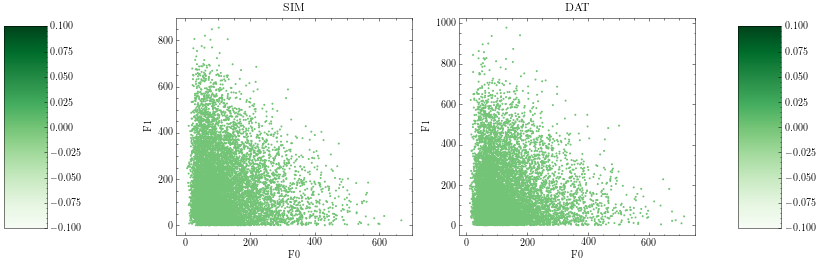

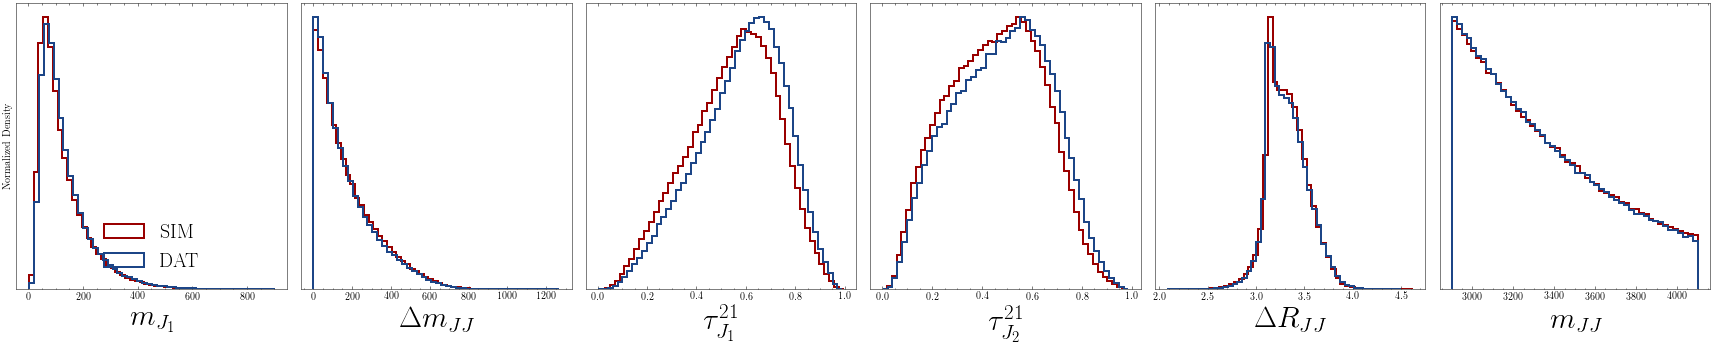

In [7]:
n_plot = 10000
bins = 50
dpi = 800

# Scatterplot the features
fig = scatterplot_features(herwig_bkg, pythia_bkg_w_inj, bins, n_features, feature_labels, n_plot = n_plot)
fig.show()


# 1D histograms
labels = ["$m_{J_1}$", "$\Delta m_{JJ}$", "$\\tau^{21}_{J_1}$", "$\\tau^{21}_{J_2}$", "$\Delta R_{JJ}$", "$m_{JJ}$"]


fig = plot_feature_histograms(herwig_bkg, pythia_bkg_w_inj, bins, n_features, labels)
fig.savefig(f"paper_plots/LHC_datasets.pdf", dpi = dpi)

fig.show()


In [8]:
# save everything out

dataset_config_string = f"LHCO_{num_signal_to_inject}sig_f/"
data_dir = os.path.join(feta_dir, dataset_config_string, "data")

print("Making dataset directory at", data_dir, "...")
os.makedirs(data_dir, exist_ok=True)

# prepare the density estimation datasets
train_herwig = pull_from_mass_range(herwig_bkg, [bands_dict["sb1"], bands_dict["sr"], bands_dict["sb2"]])
sb1_sb2_pythia = pull_from_mass_range(pythia_bkg_w_inj, [bands_dict["sb1"], bands_dict["sb2"]])

print("SB training set:")
print(train_herwig.shape,sb1_sb2_pythia.shape )
# split the data into train-val
sim_train, sim_val = train_test_split(train_herwig, test_size=0.2, random_state=8)
dat_train, dat_val = train_test_split(sb1_sb2_pythia, test_size=0.2, random_state=8)

np.save(os.path.join(data_dir, "train_sim.npy"), sim_train[:, :-1])
np.save(os.path.join(data_dir, "val_sim.npy"), sim_val[:, :-1])
np.save(os.path.join(data_dir, "train_dat.npy"), dat_train[:, :-1])
np.save(os.path.join(data_dir, "val_dat.npy"), dat_val[:, :-1])

# prepare the classifier training
sr_herwig = pull_from_mass_range(herwig_bkg, [bands_dict["sr"]])
sr_pythia = pull_from_mass_range(pythia_bkg_w_inj, [bands_dict["sr"]])

print("SR training set:")
print(sr_herwig.shape,sr_pythia.shape )

np.save(os.path.join(data_dir, "classif_train_sim.npy"), sr_herwig[:, :-1])
np.save(os.path.join(data_dir, "classif_train_dat.npy"), sr_pythia[:, :-1])

Making dataset directory at /global/home/users/rrmastandrea/FETA/LHCO_0sig_f/data ...
SB training set:
(401354, 7) (232814, 7)
SR training set:
(121978, 7) (101339, 7)


## Save out a training dataset for CATHODE

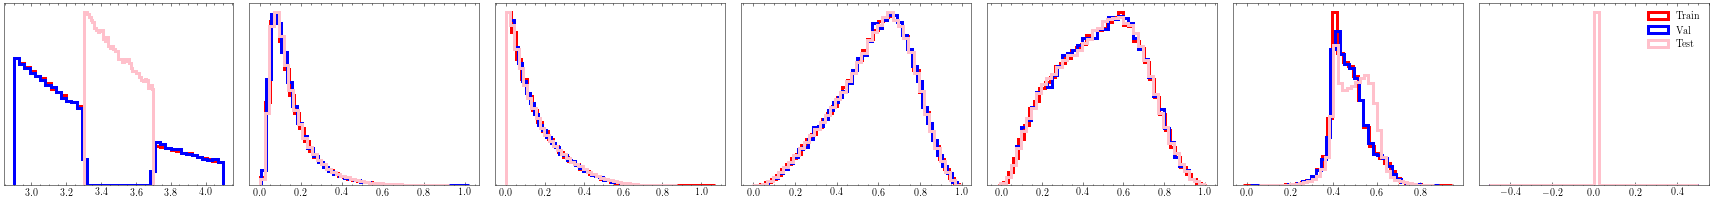

In [9]:
def prep_set_for_cathode(dset):
    
    # rescale the non-mass features
    
    dset[:,:-2] = minmaxscale(dset[:,:-2], col_minmax[:-1], lower = 0, upper  = 1.0)
    
    cathode_dset = np.zeros(dset.shape)
    
    cathode_dset[:,0] = dset[:,5] / 1000. # divide mass by 1000
    cathode_dset[:,1] = dset[:,0]
    cathode_dset[:,2] = dset[:,1]
    cathode_dset[:,3] = dset[:,2]
    cathode_dset[:,4] = dset[:,3]
    cathode_dset[:,5] = dset[:,4]
    cathode_dset[:,6] = dset[:,6]

    
    return cathode_dset


cathode_SB_data_train = prep_set_for_cathode(dat_train)
cathode_SB_data_val = prep_set_for_cathode(dat_val)
cathode_SR_data = prep_set_for_cathode(sr_pythia)

# We don't actually use these functionalities of CATHODE, so generate a trivial number
n_val = 1
cathode_SR_data_train = cathode_SR_data
dummy_data = cathode_SR_data[-n_val:]



fig, ax = plt.subplots(1, 7, figsize = (4*6, 3))

w = 3
for i in range(7):
    ax[i].hist(cathode_SB_data_train[:,i], bins = 40, density = True, label = "Train", histtype = "step", color = "red", linewidth = w)
    ax[i].hist(cathode_SB_data_val[:,i], bins = 40, density = True, label = "Val", histtype = "step", color = "blue", linewidth = w)
    ax[i].hist(cathode_SR_data_train[:,i], bins = 40, density = True, label = "Test", histtype = "step", color = "pink", linewidth = w)
        
    ax[i].set_yticks([])
    
plt.tight_layout()
plt.legend()


fig.show()


# save with labels for CATHODE
np.save(os.path.join(data_dir, "outerdata_train.npy"), cathode_SB_data_train)
np.save(os.path.join(data_dir, "outerdata_test.npy"), cathode_SB_data_val)

np.save(os.path.join(data_dir, "innerdata_train.npy"), cathode_SR_data)
np.save(os.path.join(data_dir, "innerdata_val.npy"), dummy_data)
np.save(os.path.join(data_dir, "innerdata_test.npy"), dummy_data)
